In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_venn import venn2

In [172]:
books = pd.read_csv('../data/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})
members = pd.read_csv('../data/SCoData_members_v1.2_2022_01.csv', encoding='utf-8')
events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')

C:\Users\dittm\AppData\Local\Temp\ipykernel_22976\1388952493.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')


In [173]:
total_members = len(members)
print('%d members' % len(members))

5235 members


In [174]:
def percent_known(members, field):
  total = len(members)
  with_field = len(members[members[field].notnull()])
  print('%d with %s : %.00f%%' % (with_field, field, (with_field/total)*100))
  return with_field

In [175]:
total_known = {}
for field in ['title', 'gender', 'birth_year', 'death_year', 'nationalities', 'viaf_url', 'wikipedia_url']:
    total_known[field] = percent_known(members, field)

print(total_known)

3673 with title : 70%
4039 with gender : 77%
561 with birth_year : 11%
544 with death_year : 10%
581 with nationalities : 11%
520 with viaf_url : 10%
358 with wikipedia_url : 7%
{'title': 3673, 'gender': 4039, 'birth_year': 561, 'death_year': 544, 'nationalities': 581, 'viaf_url': 520, 'wikipedia_url': 358}


In [176]:
unknown = members
for field in ['title', 'gender', 'birth_year', 'death_year', 'nationalities', 'viaf_url', 'wikipedia_url']:
  unknown = unknown[unknown[field].isnull()]

print(f'{len(unknown):,} members with no demographic info')

1,183 members with no demographic info


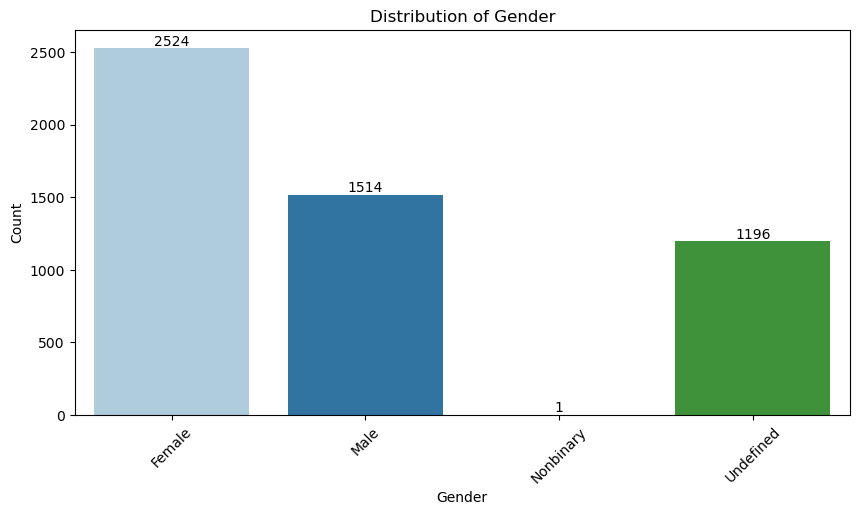

Mode of gender distribution: Female


In [177]:
# calculate mode
mode_gender = members['gender'].mode()[0]

# count undefined values
undefined_gender_count = members['gender'].isna().sum()

#count defined values
count_gender = members['gender'].replace(np.nan, 'Undefined').value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=count_gender.index, y=count_gender.values, ax=ax, palette='Paired')

# annotate each bar with its count value
for i, count in enumerate(count_gender.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Distribution of Gender')

# rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

print(f"Mode of gender distribution: {mode_gender}")

In [178]:
is_organization_members = members[members['is_organization'] == True]['sort_name'].unique().tolist() # using .unique() bc British Institute appears twice
is_organization_members

['Bibliothèque de Périgneux',
 'British Institute',
 'Europe Nouvelle',
 'Guilde Internationale',
 'Librairie des deux Lycée',
 'Mesures',
 'Nouvelle Revue Critique',
 'Revues, Les',
 'Rhein Verlag',
 'Synops']

In [179]:
unique_counts_is_organization = members['is_organization'].value_counts().sort_index()
unique_counts_is_organization

False    5224
True       11
Name: is_organization, dtype: int64

In [180]:
joint_account_events = events[events['member_uris'].str.contains(';')]
print('%d events from joint accounts' % len(joint_account_events))
print('%d joint accounts' % len(joint_account_events.member_uris.unique()))

557 events from joint accounts
49 joint accounts


In [181]:
format_data = books['format'].fillna('Unknown')
counts = format_data.value_counts()
print(counts)

Book                 5512
Unknown               410
Periodical             93
Photograph              2
Phonograph Record       1
Article                 1
Prints                  1
Name: format, dtype: int64


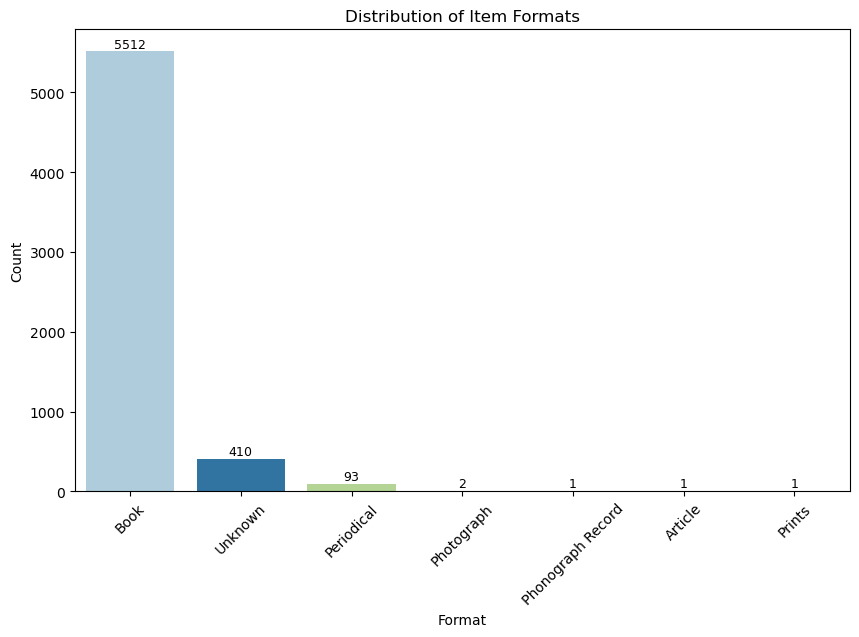

In [182]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values, palette='Paired')
plt.title('Distribution of Item Formats')
plt.xlabel('Format')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, count in enumerate(counts.values):
    ax.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=9)

plt.show()

In [183]:
event_types = events.groupby(['event_type']).size().reset_index(name='count').sort_values(['count'], ascending=False)
event_types

,event_type,count
0,Borrow,21059
10,Subscription,4839
7,Renewal,4799
6,Reimbursement,3126
5,Purchase,818
1,Crossed out,285
2,Generic,252
11,Supplement,190
9,Separate Payment,85
8,Request,28


In [184]:
def filter_events(event_type, author_name=None):
    df = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8', low_memory=False)
    df = df[['start_date', 'event_type', 'item_authors']].dropna()
    df['start_date'] = df['start_date'].str.replace('\D+', '', regex=True).str[:4].astype(int)
    # I chose to filter with <= 1941 because the bookstore officially closed in 1941. After this they occasionally sold or lend books but the bookstore itself didn't exist anymore
    df =  df[(df['start_date'].astype(str).str.match('^19[1-4]\d$')) & (df['start_date'] <= 1941)]
    df = df.loc[df['event_type'] == event_type]
    # in case it should be filtered by author
    if author_name is not None:
        df = df[df['item_authors'].astype(str).str.match(author_name)]
    df['start_date'] = pd.to_datetime(df['start_date'], format='%Y')
    count = df['start_date'].dt.year.value_counts()
    count = count.sort_index()
    return count

In [185]:
borrow_count = filter_events('Borrow')
purchase_count = filter_events('Purchase')

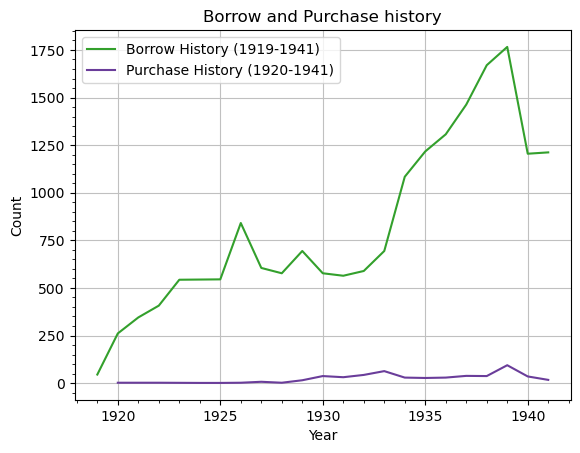

In [186]:
sns.lineplot(x=borrow_count.index, y=borrow_count.values, label='Borrow History (1919-1941)', color='#33a02c')

sns.lineplot(x=purchase_count.index, y=purchase_count.values, label='Purchase History (1920-1941)', color='#6a3d9a')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Borrow and Purchase history')
plt.legend()

plt.grid(which='major', color='silver', linewidth=0.8)
plt.minorticks_on()

plt.show()

In [187]:
popular_authors = books[books['format'] == 'Book'][['author', 'title', 'format', 'year', 'borrow_count']].dropna()
popular_authors = popular_authors[~popular_authors['author'].str.contains(';')] # ~ negates condition
popular_authors = popular_authors[(popular_authors['year'] >= 1919) & (popular_authors['year'] <= 1941)] # book published between 1919 and 1941
# sco_books_aut = sco_books_aut[(sco_books_aut['borrow_count'] >= 0)]
popular_authors.shape

(3512, 5)

In [188]:
author_book_ratio = popular_authors.groupby(['author']).size()

sorted_total_books = author_book_ratio.sort_values(ascending=False)

top_20_total = sorted_total_books.head(20)

top_20_total

author
Lawrence, D. H.           34
Walpole, Hugh             26
Huxley, Aldous            25
Wells, H. G.              23
Mackenzie, Compton        22
Maugham, W. Somerset      21
Galsworthy, John          20
Eliot, T. S.              20
Fletcher, Joseph Smith    20
Yeats, William Butler     19
Woolf, Virginia           17
Bennett, Arnold           16
Russell, Bertrand         16
Christie, Agatha          16
Wodehouse, P. G.          16
Kaye-Smith, Sheila        15
Stern, G. B.              15
Chesterton, G. K.         15
Young, Francis Brett      15
Ford, Ford Madox          14
dtype: int64

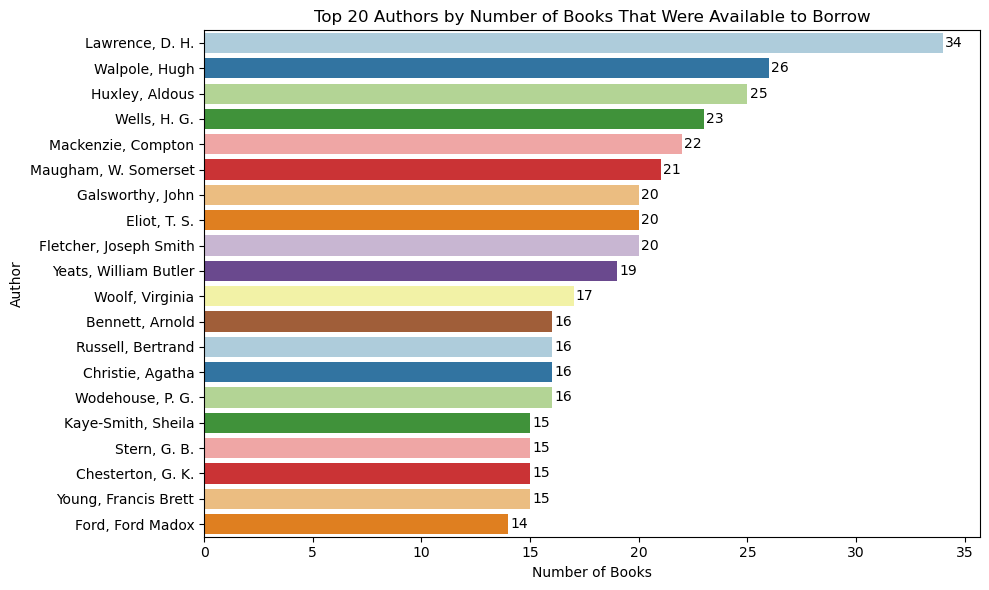

In [189]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_total.values, y=top_20_total.index, palette='Paired', orient='h')

# Add annotations
for index, value in enumerate(top_20_total.values):
    plt.text(value + 0.1, index, str(value), ha='left', va='center')

plt.title('Top 20 Authors by Number of Books That Were Available to Borrow')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

In [190]:
lawrence_count = filter_events('Borrow','Lawrence, D. H.')
walpole_count = filter_events('Borrow','Walpole, Hugh')
huxley_count = filter_events('Borrow','Huxley, Aldous')
wells_count = filter_events('Borrow','Wells, H. G.')

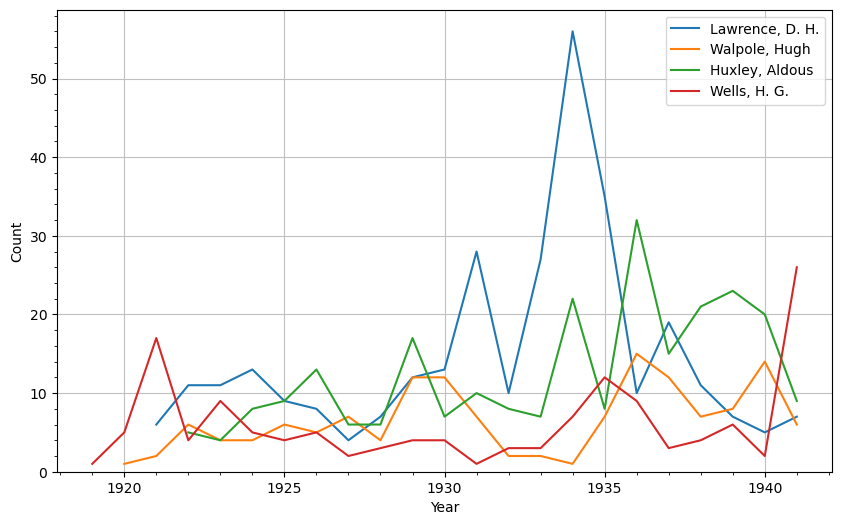

In [191]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=lawrence_count.index, y=lawrence_count.values, label='Lawrence, D. H.')
sns.lineplot(x=walpole_count.index, y=walpole_count.values, label='Walpole, Hugh')
sns.lineplot(x=huxley_count.index, y=huxley_count.values, label='Huxley, Aldous')
sns.lineplot(x=wells_count.index, y=wells_count.values, label='Wells, H. G.')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('')
plt.legend()
plt.grid(which='major', color='silver', linewidth=0.8)
plt.minorticks_on()

#ensure that the y-axis starts at 0
plt.ylim(bottom=0)

plt.show()

In [192]:
def author_items(author):
    df = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8', low_memory=False)
    df = df[['start_date', 'event_type', 'item_authors', 'item_title']].dropna()
    df['start_date'] = df['start_date'].str.replace('\D+', '', regex=True).str[:4].astype(int)
    borrow =  df[(df['start_date'].astype(str).str.match('^19[1-4]\d$')) & (df['start_date'] <= 1941)] 
    borrow = borrow[(borrow['item_authors'].astype(str).str.match(author)) & borrow['event_type'].astype(str).str.match('^Borrow$')]
    item_counts = borrow[['event_type', 'item_title']].groupby('item_title').count()
    item_counts.columns = ['borrow_count']
    item_counts = item_counts.sort_values(by='borrow_count', ascending=False)
    item_counts = item_counts.reset_index()
    return item_counts

lawrence_borrow = author_items('^Lawrence, D. H.$')
huxley_borrow = author_items('^Huxley, Aldous$')

In [193]:
# function to plot horizontal bar plot
def plot_barh(title, x_label, y_label, data, column):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_label, y=column, data=data, palette='Paired')

    # annotate each bar with its value
    for i, v in enumerate(data[x_label]):
        plt.text(v, i, str(v), color='black', fontsize=8, va='center')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
    sns.despine()

    plt.show()

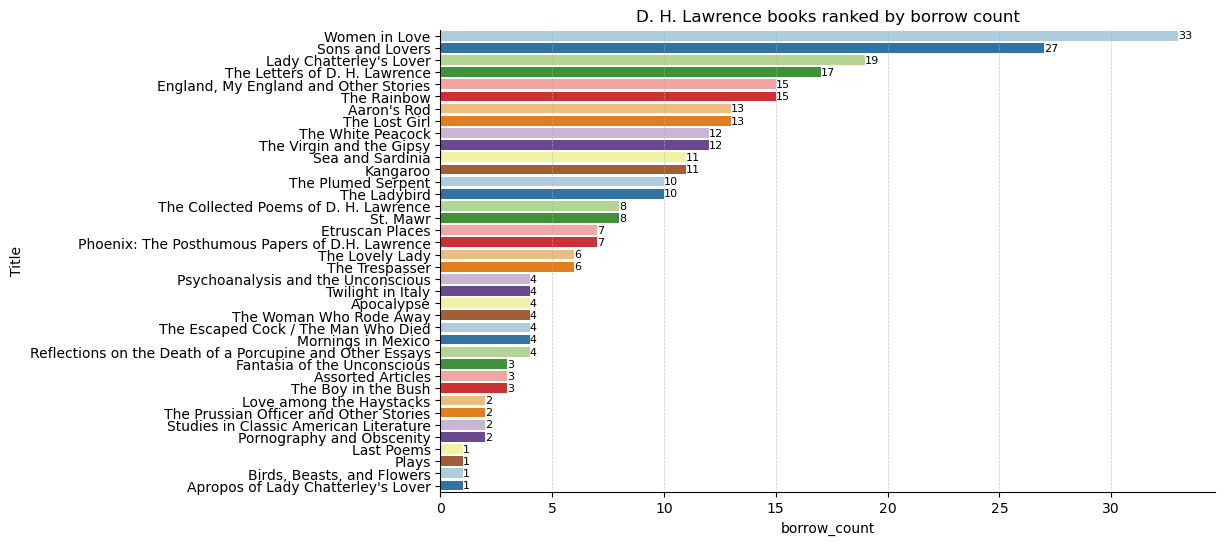

In [194]:
plot_barh('D. H. Lawrence books ranked by borrow count', 'borrow_count', 'Title', lawrence_borrow, 'item_title')

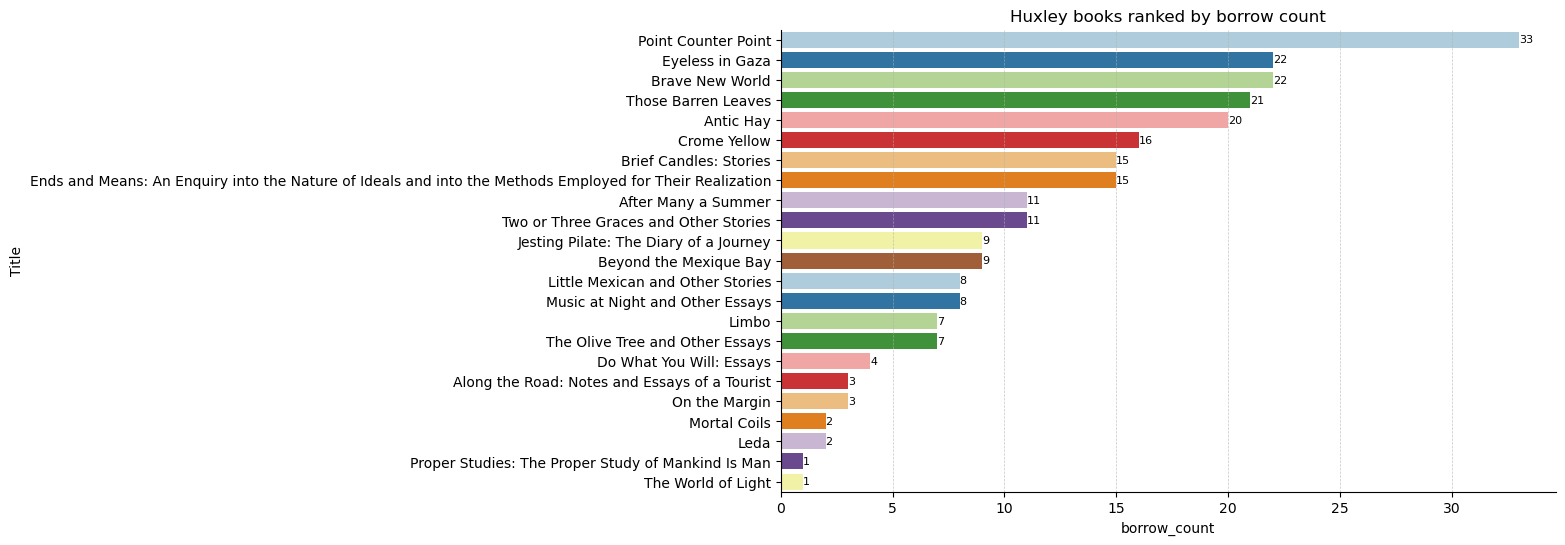

In [195]:
plot_barh('Huxley books ranked by borrow count', 'borrow_count', 'Title', huxley_borrow, 'item_title')

In [196]:
# filter data for books in 'Book' format and select top 15 based on borrow count
top_borrowed_books = books[books['format'] == 'Book'][['title', 'borrow_count', 'format']].nlargest(15, 'borrow_count')

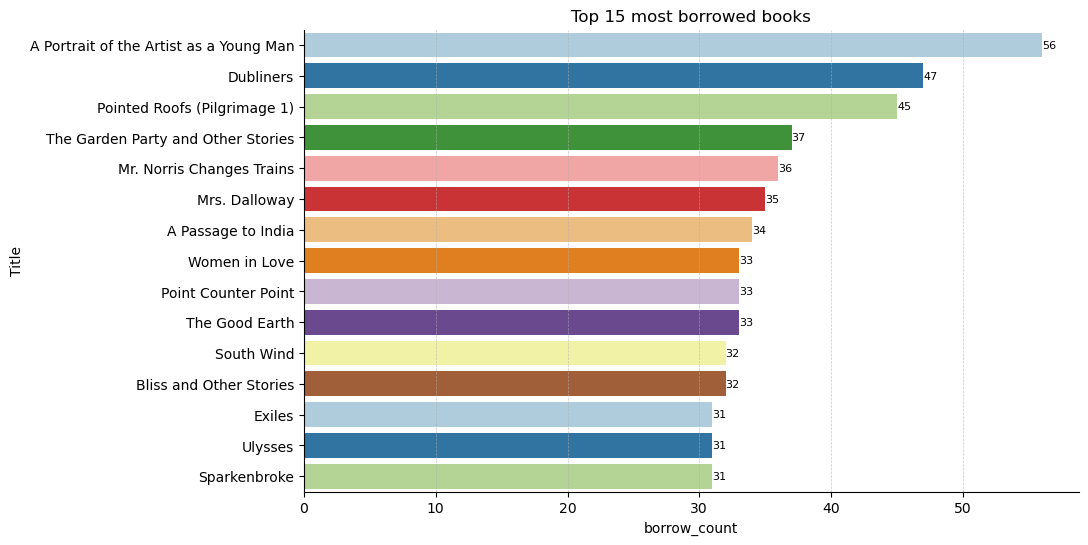

In [197]:
plot_barh('Top 15 most borrowed books', 'borrow_count', 'Title', top_borrowed_books, 'title')

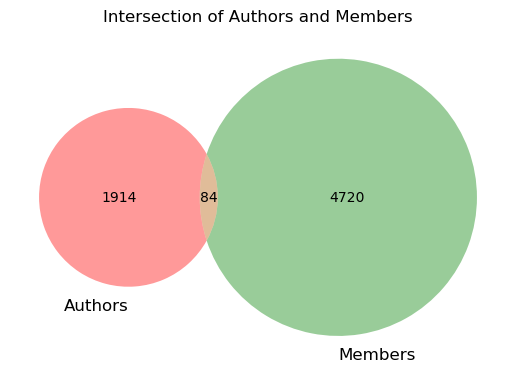

In [198]:
# Extract unique authors and members

valid_books = books.dropna(subset='author')
valid_members = members.dropna(subset='sort_name')

unique_authors = set(valid_books['author'])
unique_members = set(valid_members['sort_name'])

# Calculate the intersection
intersection = len(unique_authors.intersection(unique_members))

# Create the Venn diagram for authors
venn2(subsets=(len(unique_authors) - intersection, len(unique_members) - intersection, intersection),
      set_labels=('Authors', 'Members'))
plt.title('Intersection of Authors and Members')
plt.show()

In [202]:
intersection

84